# 데이터 불러오기

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


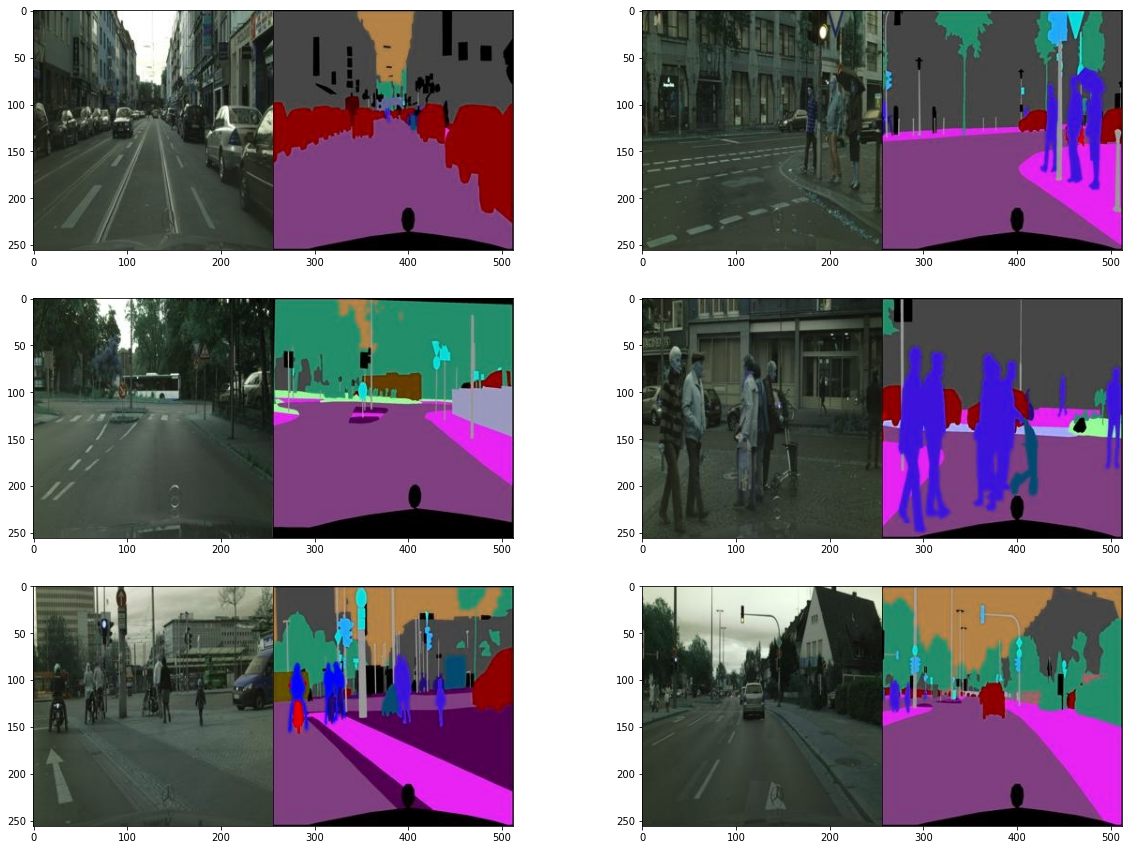

In [2]:
#1000개의 이미지 중에서 6장의 이미지를 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    #f는 1000개의 이미지 중 일부를 랜덤으로 가져올 때 사용
    #os.listdir를 사용하여 해당 경로에 모든 파일의 이름을 리스트로 리턴
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
#이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


# 이미지 전처리

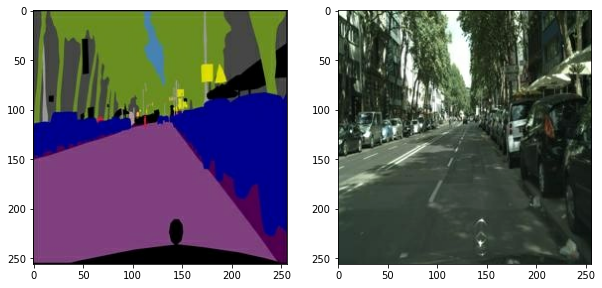

In [4]:
#이미지 분리를 위해 사용
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

#복원시 사용하는 함수
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32) #
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(seg), normalize(colored)

#f는 위에서 정의했듯, listdir경로의 모든 파일을 리스트화하고 그 중 하나를 랜덤하게 가져옴
f = data_path + os.listdir(data_path)[1]
seg, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [9]:
#data의 부족으로 인한 augumentation 진행
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용 
def apply_augmentation(seg, colored):
    stacked = tf.concat([seg, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    #50% 확률로 reflection, constant padding 적용
    #reflect padding은 가까운 픽셀값을 가져와서 결과적으로는 좌우 반전이 되는 것처럼 만듬
    if tf.random.uniform(()) < .5: 
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    
    #이미지를 임의로 잘라낼 때 사용
    out = image.random_crop(padded, size=[256, 256, 6])
    
    #이미지를 가로로 뒤집기
    out = image.random_flip_left_right(out) 
    #이미지를 세로로 뒤집기
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        #이미지 회전
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

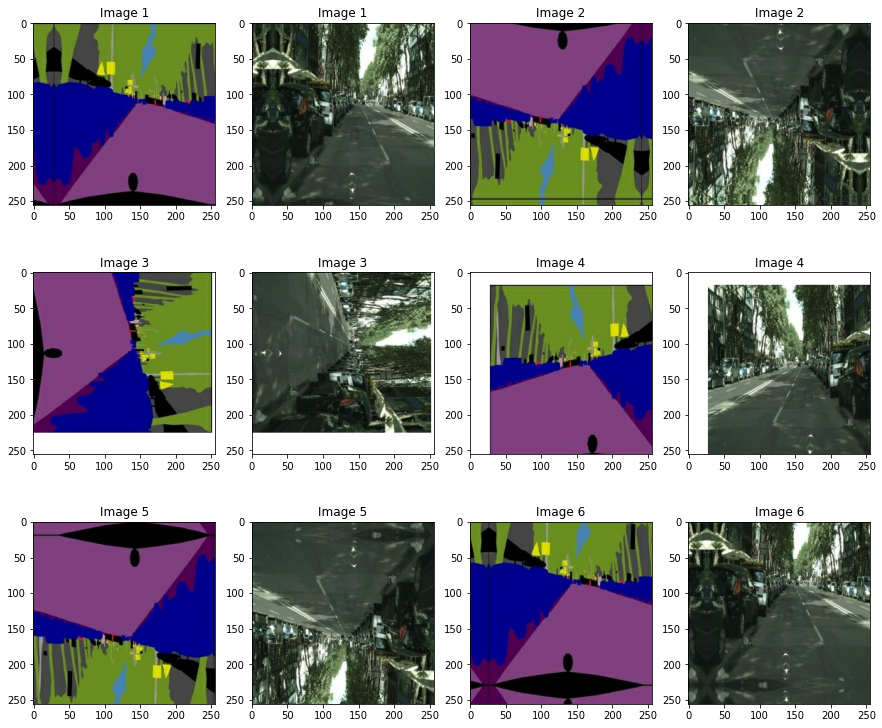

In [10]:
#시각화하여 위의 과정이 잘 되었는지 확인
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_colored = apply_augmentation(seg, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

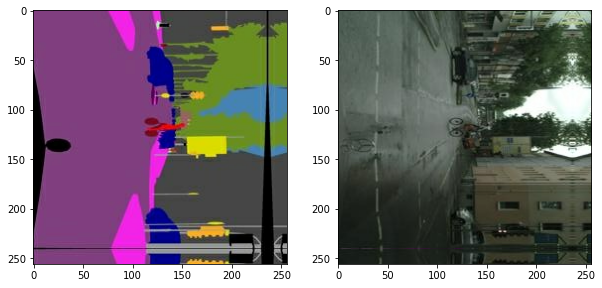

In [11]:
#전체 데이터셋에 적용하고 하나만 시각화
from tensorflow import data

def get_train(img_path):
    seg, colored = load_img(img_path)
    seg, colored = apply_augmentation(seg, colored)
    return seg, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 모델구현

### generator

In [12]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [13]:
#기존 encoder에서 skip-connection 추가

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        # encoder의 마지막 출력은 decoder로 직접 입력되므로 skip connection의 대상이 아님
        features = features[:-1]
                    
        #skip-connection은 인코더 처음과 디코더 끝 등의 대칭을 이룸. 디코더에서 차례대로 사용하기위해서
        #feature의 역순으로 연결함
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [14]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### generator

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [16]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* 128 128 32가 패딩레이어를 통과하면서 130 130 32가 됨.(패딩기본값1, 양옆에 하나씩 붙어서 2가되는듯)
* conv레이어를 통과하면서 127 127 64가 됨.(필터크기4, 130-4+1해서 127)

In [17]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        #위의 층을 for 반복문을 이용하여서 구현할 수 있는 방법
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [18]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

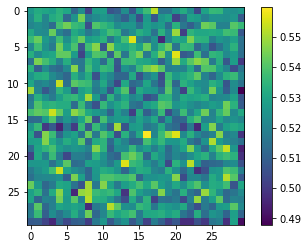

In [20]:
#훈련하지 않은 채로 이미지 생성 확인
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 학습 및 테스트

In [22]:
#손실함수 지정 부분
from tensorflow.keras import losses

#bce = binary cross entropy
#mae = mean square error

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [23]:
#optimizer부분. 논문과 동일
#논문제목 : Image-to-Image Translation with Conditional Adversarial Networks
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100(=L1 loss 가중치를100으로 설정)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [25]:
#훈련시작
EPOCHS = 15

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8439                     
L1_loss:0.2874                     
Discriminator_loss:1.3132

EPOCH[1] - STEP[20]                     
Generator_loss:0.9315                     
L1_loss:0.2493                     
Discriminator_loss:1.4152

EPOCH[1] - STEP[30]                     
Generator_loss:0.9156                     
L1_loss:0.1843                     
Discriminator_loss:1.3403

EPOCH[1] - STEP[40]                     
Generator_loss:0.8556                     
L1_loss:0.2016                     
Discriminator_loss:1.3507

EPOCH[1] - STEP[50]                     
Generator_loss:0.8173                     
L1_loss:0.1912                     
Discriminator_loss:1.1455

EPOCH[1] - STEP[60]                     
Generator_loss:1.2547                     
L1_loss:0.1800                     
Discriminator_loss:1.4349

EPOCH[1] - STEP[70]                     
Generator_loss:0.8695                     
L1_loss:0.1800                    

# 훈련을 바탕으로 한 도로 이미지 생성

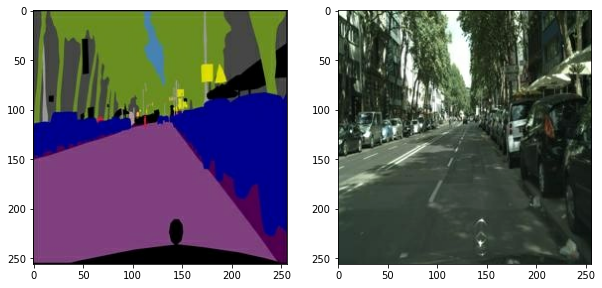

In [40]:
#이미지 분리를 위해 사용
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

#복원시 사용하는 함수
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    seg = img[:, w:, :] 
    seg = tf.cast(seg, tf.float32) #
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(seg), normalize(colored)

#f는 위에서 정의했듯, listdir경로의 모든 파일을 리스트화하고 그 중 하나를 랜덤하게 가져옴
f = data_path + os.listdir(data_path)[1]
seg, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [41]:
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/val/'

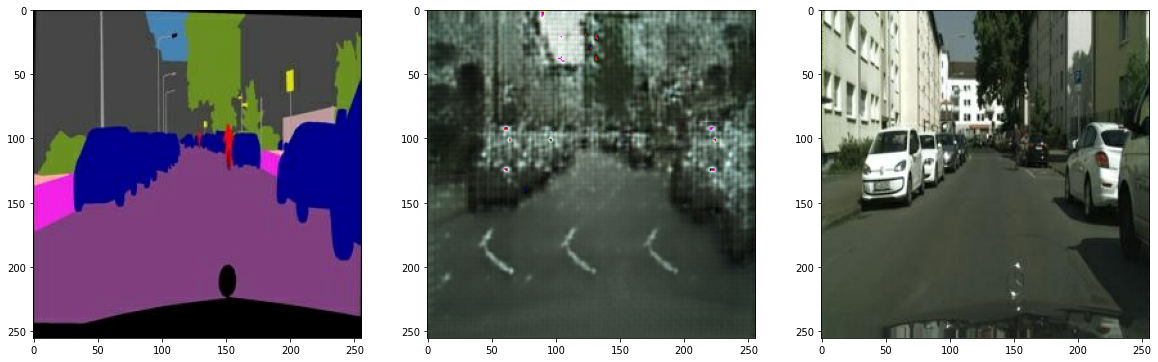

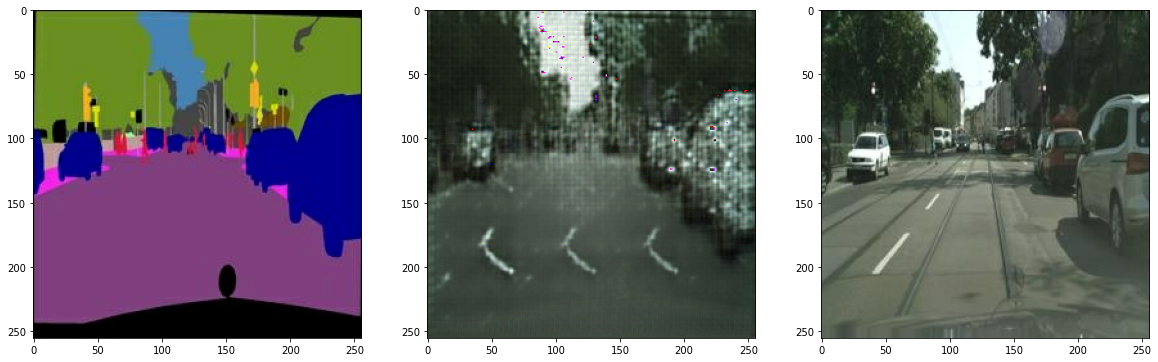

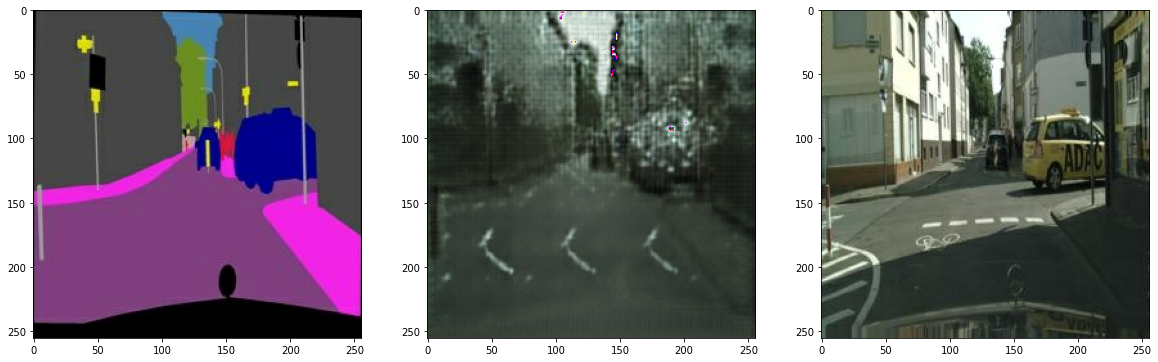

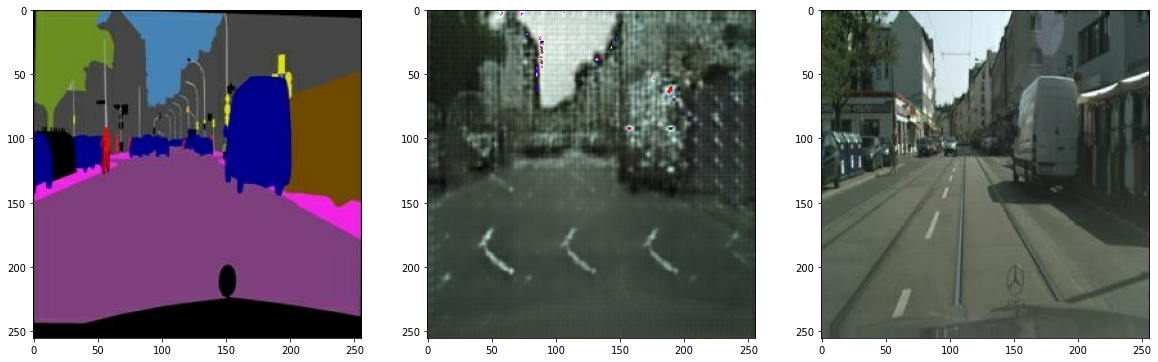

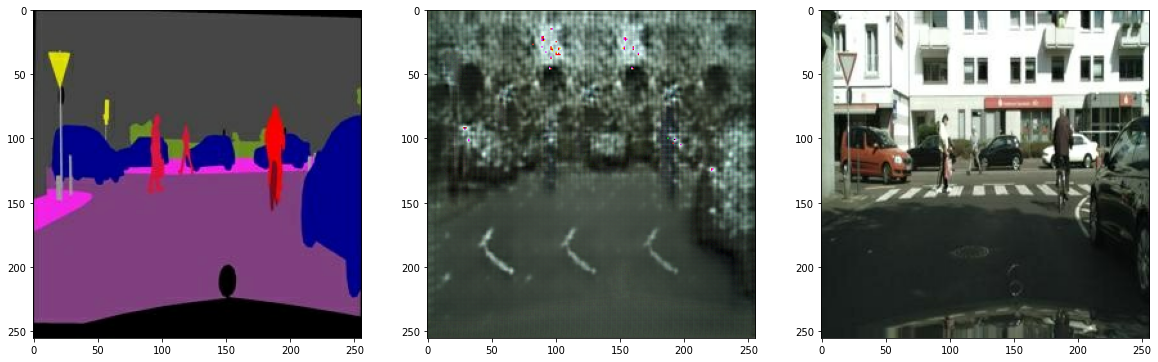

In [42]:
for i in range(5):
    test_ind = i

    f = val_path + os.listdir(val_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 회고

논문을 바탕으로 도로 이미지 만들기에 성공하였습니다.

1000장의 이미지를 사용했기에 충분한 자료를 사용한 줄 알았으나, 결과를 보니 왜 모자라다는 말이 나왔는지 알 것 같습니다.

일직선인 도로임에도 하얀색 선이 일괄적으로 구부러져 있는 것을 보면 더 다양한 이미지가 필요하지 않았을까... 라는 생각이 듭니다.

15에포치만 돌렸는데, 위의 문제를 제외하고는 어느정도 올바른 도로를 생성해냈습니다. 다만 아쉬운 점은 도로를 제외한 나머지 부분에 노이즈가 껴서 알아보기 힘들다는 점입니다.

결과가 좋지 않을 것이라는 설명이 있었음에도 기대했지만, 예상치에 미치지 못하였습니다.

훈련을 하는 것도 중요하지만, 자료가 더 많이 있는 것이 가장 좋겠다는 생각이 듭니다.